# Задача: на основании данных о клиентах и их покупках определить эффективность программы лояльности.

- Приносят ли покупатели участвующие в программе лояльности со временем прибыль больше, чем не участвующие.  
- Чаще ли они совершают покупки (возвращаются)  
- Больше ли их средний чек и количество покупаемых товаров  

#### Презентация: https://drive.google.com/file/d/1wBt-Q1qqUE7CFUTVoOtIZd-q_fxbK6mf/view?usp=sharing

#### Дашборд: https://public.tableau.com/views/_16273413492640/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

## Содержание
1. [Изучение общей информации](#paragraph1)
2. [Предобработка данных](#paragraph2)
3. [Исследовательский анализ данных](#paragraph3)
    1. [Суммы чеков](#subparagraph1)
    2. [Когорты](#subparagraph2)
    3. [Retention Rate](#subparagraph3)
    4. [LTV](#subparagraph4)
    5. [Среднее количество товаров и средний чек](#subparagraph5)
    6. [Возвраты](#subparagraph6)  
4. [Выводы](#paragraph4)

In [1]:
import pandas as pd
import seaborn as sns
import datetime as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Загрузить и изучить основную информацию о данных. <a name="paragraph1"></a>

In [2]:
try:
    retail = pd.read_csv('C:/Users/Natasha/Documents/аналитика данных/аналитика данных/Projects/retail_dataset.csv')
    products = pd.read_csv('C:/Users/Natasha/Documents/аналитика данных/аналитика данных/Projects/product_codes.csv')
except FileNotFoundError:
    retail = pd.read_csv('/datasets/retail_dataset.csv')
    products = pd.read_csv('/datasets/product_codes.csv')

In [3]:
display(retail.head())
display(retail.info())

display(products.head())
display(products.info())

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


None

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


None

Нам предоставили 2 датасета с данным. retail содержит данные о покупках, products данные о ценах на товары.
Перед анализом данных преобработаем их.

## Предобработка данных (пропуски, дубликаты, типы). <a name="paragraph2"></a>

### Обработка колонок: типы и названия.

In [4]:
retail.columns = retail.columns.str.lower()
products.columns = ['item_id', 'price_per_one']

In [5]:
display(retail.dtypes)
display(products.dtypes)

purchaseid          object
item_id             object
quantity             int64
purchasedate        object
customerid         float64
shopid              object
loyalty_program    float64
dtype: object

item_id           object
price_per_one    float64
dtype: object

Преобразуем колонку с временем в верный формат.

In [6]:
retail['purchasedate'] = pd.to_datetime(retail['purchasedate'], format = '%Y-%m-%d %H:%M:%S')

Теперь типы приведены к верным.

### Поиск и обработка дубликатов.

In [7]:
print(products.duplicated().sum())
print(retail.duplicated().sum())

0
1033


In [8]:
retail.drop_duplicates(inplace=True)

### Поиск пропусков. 

In [9]:
retail.isna().sum()

purchaseid             0
item_id                0
quantity               0
purchasedate           0
customerid         36148
shopid                 0
loyalty_program        0
dtype: int64

In [10]:
print('{:.2%}'.format(retail['customerid'].isna().sum() / len(retail)))

34.66%


36 тысяч пропусков среди покупателей - это почти 35% от общего массива данных. Терять такой объем нежелательно, попробуем заполнить.
Уникальные значения в датасете - это чеки purchaseid. Попробуем на их основе заполнить пропуски покупателей.


### Обработка пропусков.

In [11]:
retail[retail['customerid'].isna()]

,purchaseid,item_id,quantity,purchasedate,customerid,shopid,loyalty_program
6,540468,22189,0,2017-01-07 13:55:00,NaN,Shop 0,0.0
7,541424,79321,1,2017-01-17 17:57:00,NaN,Shop 0,0.0
8,538883,22891,0,2016-12-14 15:56:00,NaN,Shop 0,0.0
11,541696,22197,4,2017-01-20 18:08:00,NaN,Shop 0,0.0
16,539744,22300,5,2016-12-21 15:21:00,NaN,Shop 0,0.0
...,...,...,...,...,...,...,...
105325,536982,20719,69,2016-12-03 14:27:00,NaN,Shop 0,0.0
105326,540681,22227,1,2017-01-10 16:25:00,NaN,Shop 0,0.0
105327,538349,22625,0,2016-12-10 14:59:00,NaN,Shop 0,0.0
105329,540154,22134,3,2017-01-05 11:30:00,NaN,Shop 0,0.0


In [12]:
print('Чеков всего', retail['purchaseid'].nunique())
print('Уникальных покупателей', retail['customerid'].nunique())

Чеков всего 4894
Уникальных покупателей 1749


In [13]:
purchaseid_list = retail[['purchaseid', 'customerid']].dropna().drop_duplicates() #удалим дубликаты чек-покупатель
purchaseid_list #список уникальных пар чек - покупатель

,purchaseid,customerid
0,538280,18427.0
1,538862,22389.0
2,538855,22182.0
3,543543,23522.0
4,543812,23151.0
...,...,...
104498,C542640,22518.0
104590,537229,23356.0
104703,C543551,22395.0
104734,544612,23766.0


In [14]:
retail_edited = retail.merge(purchaseid_list, on='purchaseid', how='left')

In [15]:
retail_edited.drop(columns='customerid_x', inplace=True)
retail_edited.rename(columns = {'customerid_y':'customerid'}, inplace=True)
retail_edited['customerid'].isna().sum()

36148

По уникальному значению чека заполнить пропуски не удалось, значит, оставим всех этих покупателей неидентифицированными. Чтобы избежать пустых значений, заполним их номерами чеков, так нам удастся их сохранить для расчетов и поможет учитывать их как уникальные значения. 

Проверим, что не существует никакого purchaseid который совпадал бы с customerid. 

In [16]:
unique_purchaseid = retail_edited['purchaseid'].unique()
unique_customerid = retail_edited['customerid'].unique()
for i in unique_customerid:
    if str(i) in unique_purchaseid:
        print('Yes')

In [20]:
x = retail_edited.loc[retail_edited['customerid'].isna(), 'purchaseid']
retail_edited.loc[retail_edited['customerid'].isna(), 'customerid'] =x

In [21]:
retail_edited['customerid'].isna().sum()

0

In [22]:
print('Уникальных покупателей', retail_edited['customerid'].nunique())

Уникальных покупателей 2497


По чекам добавилось 748 уникальных покупателей.

## Исследовательский анализ данных. <a name="paragraph3"></a>

### Подтянуть цены в основной датафрейм и рассчитать суммы чеков <a name="subparagraph1"></a>

In [23]:
products['item_id'].nunique() #уникальные товары
products.sort_values(by='item_id')

,item_id,price_per_one
31,10002,0.85
8122,10002,1.63
2459,10002,1.66
9886,10080,0.85
2432,10120,0.21
...,...,...
9601,gift_0001_30,25.00
6178,gift_0001_30,25.53
5580,gift_0001_40,34.04
5975,gift_0001_50,42.55


Видно, что у товаров по несколько цен. Посмотрим сколько всего цен в среднем цен у товаров.

In [24]:
print('Всего товаров', products['item_id'].nunique())
products.groupby(by='item_id').count().mean()

Всего товаров 3159


price_per_one    3.155745
dtype: float64

In [25]:
products

,item_id,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39
...,...,...
9964,84306,8.29
9965,90001A,4.15
9966,90118,2.46
9967,DOT,172.62


Взглянем на разброс цен.

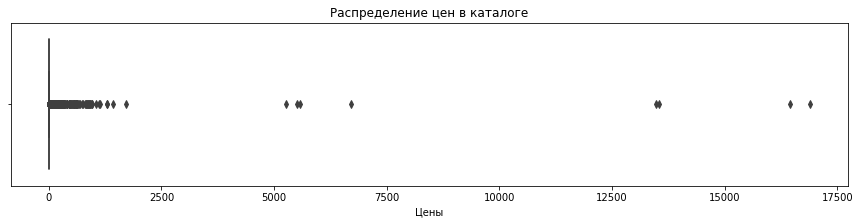

In [26]:
plt.figure(figsize=(15, 3))
ax = sns.boxplot(x = products['price_per_one'])
ax.set_title("Распределение цен в каталоге")
ax.set_xlabel('Цены')
plt.savefig('saved_figure1.png', dpi = 100, bbox_inches='tight')
#plt.show()

In [27]:
products.sort_values(by='price_per_one', ascending=False).head(10)

,item_id,price_per_one
6133,AMAZONFEE,16888.02
6134,AMAZONFEE,16453.71
3931,AMAZONFEE,13541.33
4089,AMAZONFEE,13474.79
4095,AMAZONFEE,6706.71
9732,AMAZONFEE,5575.28
4094,AMAZONFEE,5519.25
9733,AMAZONFEE,5258.77
8729,M,1715.85
9476,M,1435.79


Посмотрим на продукты.

In [28]:
products.groupby(by='item_id').count().tail(23)
#.sort_values().head(10)

,price_per_one
item_id,
AMAZONFEE,9
BANK CHARGES,8
C2,3
D,13
DCGS0003,2
DCGS0055,1
DCGS0057,1
DCGS0069,1
DCGS0070,1


В десятке первых цен - комиссии за продажу товаров на Amazon. Это не относится к покупкам, поэтому нужно удалить все данные с этими списаниями. 
Помимо этого у нас еще много продуктов со странными наименованиями, не похожими на большинство остальных кодов продуктов. Смею предположить, что данные продукты - это не товары наших магазинов, а комиссии, особые списания, подарки, бонусы и тд.
Мы не будем их учитывать в дальнейшем анализе и удалим из датасетов.

In [29]:
trash_items = list(products.groupby(by='item_id').count().tail(23).index)
trash_items #список ненужных товаров

['AMAZONFEE',
 'BANK CHARGES',
 'C2',
 'D',
 'DCGS0003',
 'DCGS0055',
 'DCGS0057',
 'DCGS0069',
 'DCGS0070',
 'DCGS0072',
 'DCGS0074',
 'DCGS0076',
 'DCGSSBOY',
 'DCGSSGIRL',
 'DOT',
 'M',
 'POST',
 'S',
 'gift_0001_20',
 'gift_0001_30',
 'gift_0001_40',
 'gift_0001_50',
 'm']

In [30]:
products_clean = products[~products['item_id'].isin(trash_items)] #чистка датафреймов
retail_clean = retail_edited[~retail_edited['item_id'].isin(trash_items)]

In [31]:
print('Всего товаров', products_clean['item_id'].nunique())
products_clean.groupby(by='item_id').count().mean()

Всего товаров 3136


price_per_one    3.074298
dtype: float64

Теперь товаров в списке 3136, в среднем нам даны по три цены на товар. Взглянем на обновленное распределение.

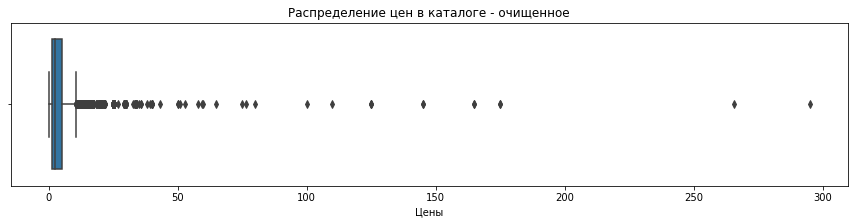

In [32]:
plt.figure(figsize=(15, 3))
ax = sns.boxplot(x = products_clean['price_per_one'])
ax.set_title("Распределение цен в каталоге - очищенное")
ax.set_xlabel('Цены')
plt.savefig('saved_figure2.png', dpi = 100, bbox_inches='tight')
plt.show()

Выглядит намного лучше без странных огромных выбросов. Большие цены все же есть, но разница не так велика, как была до этого.
Возьмем максимальную цену для товаров, у которых этих цен несколько. Руководствуемся соображением, что другие цены, отличные от максимальной, формируются исходя из акций, спец. предложений и тд. и подобное не всем доступно. 

In [33]:
prices = products_clean.groupby(by='item_id').max().reset_index()
prices.columns = ['item_id', 'price']
prices

,item_id,price
0,10002,1.66
1,10080,0.85
2,10120,0.21
3,10123C,0.65
4,10124A,0.42
...,...,...
3131,90214T,0.85
3132,90214V,1.25
3133,90214W,0.85
3134,90214Y,0.85


Присоединим к основном датафрейму и расчитаем стоимость покупок.

In [34]:
retail_final = retail_clean.merge(prices, on='item_id', how='left')
retail_final['total'] = retail_final['quantity'] * retail_final['price']
retail_final 

,purchaseid,item_id,quantity,purchasedate,shopid,loyalty_program,customerid,price,total
0,538280,21873,11,2016-12-10 12:50:00,Shop 0,0.0,18427.0,3.36,36.96
1,538862,22195,0,2016-12-14 14:11:00,Shop 0,1.0,22389.0,3.36,0.00
2,538855,21239,7,2016-12-14 13:50:00,Shop 0,1.0,22182.0,2.51,17.57
3,543543,22271,0,2017-02-09 15:33:00,Shop 0,1.0,23522.0,5.91,0.00
4,543812,79321,0,2017-02-13 14:40:00,Shop 0,1.0,23151.0,12.46,0.00
...,...,...,...,...,...,...,...,...,...
103740,538566,21826,1,2016-12-13 11:21:00,Shop 0,0.0,538566,2.51,2.51
103741,540247,21742,0,2017-01-05 15:56:00,Shop 0,0.0,21143.0,12.72,0.00
103742,538068,85048,1,2016-12-09 14:05:00,Shop 0,1.0,23657.0,16.98,16.98
103743,538207,22818,11,2016-12-10 11:33:00,Shop 0,0.0,18427.0,0.85,9.35


Обращаем также внимание, что у части покупок отражено отрицательное количество товара. Категоризируем эти данные как отмены покупок.

In [35]:
retail_final['cancel'] = retail_final['quantity'].apply(lambda x: True if x < 0 else False)

Выделим возвраты в отдельный датафрейм и очистим основной от возвратов. Их проанализируем отдельно.

### Сгруппировать покупателей на когорты в зависимости от первой покупки и по неучаствующим в ПЛ (группа 0) и участвующим (группа 1) <a name="subparagraph2"></a>

Посмотрим сколько всего у нас покупателей и как они расчпределены на группы: в ПЛ и вне ПЛ.

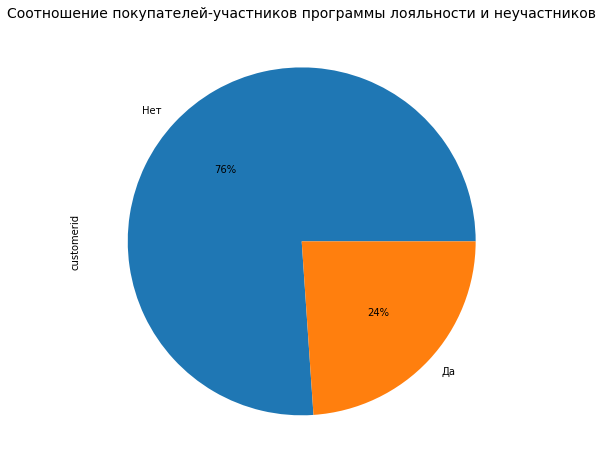

In [36]:
retail_final.groupby('loyalty_program')['customerid'].nunique().plot(kind='pie', 
                                                                      figsize=(8, 8),
                                                                      labels=('Нет', 'Да'),
                                                                      autopct='%1.f%%'
                                                                      )
plt.title('Соотношение покупателей-участников программы лояльности и неучастников', fontsize=14)
plt.savefig('saved_figure3.png', dpi = 100, bbox_inches='tight')
plt.show()

In [37]:
retail_final.to_csv('retail_final.csv', index=False)

В представленном наборе данных 74 % покупателей не участвую в программе лояльности и 26% участвуют.

Посмотрим за какой период предоставлены данные и примем решение о делении на когорты.

In [38]:
retail_final['purchasedate'].describe(datetime_is_numeric=True)

count                           103745
mean     2017-01-09 18:49:36.334859520
min                2016-12-01 08:26:00
25%                2016-12-12 14:21:00
50%                2017-01-11 12:41:00
75%                2017-02-01 15:12:00
max                2017-02-28 17:04:00
Name: purchasedate, dtype: object

У нас данные за 3 месяца, возьмем когорты по неделям.

In [39]:
first_date = retail_final.groupby('customerid')['purchasedate'].min().astype('datetime64[D]')
first_date #первые даты покупки для каждого покупателя

customerid
18025.0   2017-01-18
18026.0   2016-12-07
18027.0   2016-12-16
18029.0   2017-02-02
18031.0   2017-02-16
             ...    
C541492   2017-01-18
C542540   2017-01-28
C542860   2017-02-01
C543185   2017-02-04
C543384   2017-02-07
Name: purchasedate, Length: 2454, dtype: datetime64[ns]

In [40]:
retail_final = retail_final.merge(first_date, on='customerid')
retail_final.rename(columns = {'purchasedate_x':'purchasedate', 'purchasedate_y':'first_date'}, inplace=True)

Мы выделили дату самой первой покупки для каждого покупателя, теперь выделим неделю первой покупки и недели последующих покупок, посчитаем разницу между ними - это будет время жизни покупателя в когорте. 

In [41]:
retail_final['first_week'] = retail_final['first_date'].astype('datetime64[W]') # выделяем когорты по неделям

In [42]:
retail_final['next_week'] = retail_final['purchasedate'].astype('datetime64[W]') 

Рассчитываем время жизни когоры. Вычитаем из недель покупок первую неделю, во время которой была впервые совершена покупка.

In [43]:
retail_final['cohort_lifetime'] = retail_final['next_week'] - retail_final['first_week'] 
retail_final['cohort_lifetime'] = retail_final['cohort_lifetime'] / np.timedelta64(1, 'W')
retail_final['cohort_lifetime'] = retail_final['cohort_lifetime'].round().astype('int')

Разделим датафремы на те, что содарежат покупки и те, что содержат возвраты.

In [44]:
cancelled_retail = retail_final[retail_final['cancel'] == True]
purchase_retail = retail_final[retail_final['cancel'] == False]

In [45]:
# считаем количество покупателей в нулевом lifetime каждой когорты в разрезе программы лояльности
cohorts = purchase_retail.pivot_table(index='first_week', 
                                     columns='loyalty_program', 
                                     values='customerid', 
                                     aggfunc='nunique').reset_index()
cohorts = cohorts.rename(columns={0.0:'loyalty_0', 1.0:'loyalty_1'})


Выделили когорты. Вглянем на количество покупателей в каждой и их процентное соотношение.

In [46]:
cohorts['loyalty_0_%_part'] = (cohorts['loyalty_0'] / (cohorts['loyalty_1'] + cohorts['loyalty_0']) * 100).astype(int)
cohorts['loyalty_1_%_part'] = (cohorts['loyalty_1'] / (cohorts['loyalty_1'] + cohorts['loyalty_0']) * 100).astype(int)
cohorts

loyalty_program,first_week,loyalty_0,loyalty_1,loyalty_0_%_part,loyalty_1_%_part
0,2016-12-01,346,157,68,31
1,2016-12-08,252,116,68,31
2,2016-12-15,178,52,77,22
3,2016-12-22,26,2,92,7
4,2016-12-29,17,3,85,15
5,2017-01-05,115,40,74,25
6,2017-01-12,97,23,80,19
7,2017-01-19,104,25,80,19
8,2017-01-26,110,39,73,26
9,2017-02-02,104,29,78,21


Процентное соотношение наполненности когорт близко к общему соотношению. Сильно различие только в когорте 2016-12-22.

In [47]:
#коготры по участию в программе лояльности
cohorts_0 = purchase_retail[purchase_retail['loyalty_program'] == 0].groupby(['first_week', 
                                                      'cohort_lifetime']).agg({'customerid':'nunique', 
                                                                              'total':'sum'}).reset_index()
cohorts_1 = purchase_retail[purchase_retail['loyalty_program'] == 1].groupby(['first_week', 
                                                      'cohort_lifetime']).agg({'customerid':'nunique',
                                                                               'total':'sum'}).reset_index()

Разделили когорты на два датасета, приступим к рассчету метрик, которые покажут эффективнось работы программы лояльности.

### Рассчитать Retention Rate по когортам. Построить графики <a name="subparagraph3"></a>

Retention Rate — это коэффициент удержания клиентов. Он показывает, насколько долго остаются постоянные клиенты с компанией. В нашем случае мы увидим как часто возвращаются покупатели снова и снова.
Это важно, ведь они более лояльная аудитория для повторных продаж и помогают увеличивать прибыль, привлекают новых клиентов за счет рекомендаций.

Высокий коэффициент Retention Rate означает, что наша тактика ведения бизнеса и наша программа лояльности приносят прибыль и удерживают большой процент клиентов.

In [48]:
cohorts_0 = cohorts_0.merge(cohorts[['first_week', 'loyalty_0']], on='first_week')
cohorts_0 = cohorts_0.rename(columns={'loyalty_0':'customerid_all'})
cohorts_0['retention'] = cohorts_0['customerid'] / cohorts_0['customerid_all']
cohorts_0

,first_week,cohort_lifetime,customerid,total,customerid_all,retention
0,2016-12-01,0,332,350457.95,346,0.959538
1,2016-12-01,1,62,100086.41,346,0.179191
2,2016-12-01,2,56,99583.89,346,0.161850
3,2016-12-01,3,8,3362.77,346,0.023121
4,2016-12-01,4,10,6890.81,346,0.028902
...,...,...,...,...,...,...
73,2017-02-09,0,70,37201.77,70,1.000000
74,2017-02-09,2,1,237.38,70,0.014286
75,2017-02-16,0,95,65797.57,95,1.000000
76,2017-02-16,1,4,2047.20,95,0.042105


In [49]:
cohorts_1 = cohorts_1.merge(cohorts[['first_week', 'loyalty_1']], on='first_week')
cohorts_1 = cohorts_1.rename(columns={'loyalty_1':'customerid_all'})
cohorts_1['retention'] = cohorts_1['customerid'] / cohorts_1['customerid_all']
cohorts_1

,first_week,cohort_lifetime,customerid,total,customerid_all,retention
0,2016-12-01,0,155,210715.01,157,0.987261
1,2016-12-01,1,32,19202.14,157,0.203822
2,2016-12-01,2,28,26249.16,157,0.178344
3,2016-12-01,3,2,1226.49,157,0.012739
4,2016-12-01,4,4,4076.63,157,0.025478
...,...,...,...,...,...,...
69,2017-02-09,1,4,6455.06,25,0.160000
70,2017-02-09,2,1,276.48,25,0.040000
71,2017-02-16,0,23,13021.71,24,0.958333
72,2017-02-16,1,1,3669.21,24,0.041667


In [50]:
cohorts_0_retention_pivot = cohorts_0.pivot_table(index='first_week', 
                                                  columns='cohort_lifetime', 
                                                  values='retention', 
                                                  aggfunc='sum')
cohorts_0_retention_pivot.loc['mean'] = cohorts_0_retention_pivot.mean() 
# расчет среднего retention среди всех когорт по времени жизни

cohorts_1_retention_pivot = cohorts_1.pivot_table(index='first_week', 
                                                  columns='cohort_lifetime', 
                                                  values='retention', 
                                                  aggfunc='sum')
cohorts_1_retention_pivot.loc['mean'] = cohorts_1_retention_pivot.mean() 
# расчет среднего retention среди всех когорт по времени жизни

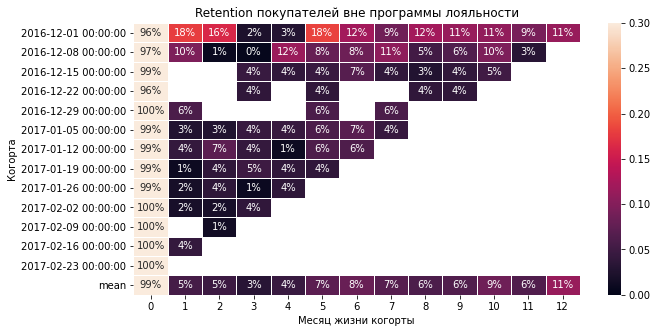

In [51]:
plt.figure(figsize=(10, 5))
plt.title('Retention покупателей вне программы лояльности')
ax = sns.heatmap(cohorts_0_retention_pivot
            , annot=True, 
            fmt='.0%', 
            linewidths=1, 
            linecolor='white', 
            vmin=0.0, 
            vmax=0.3
           )
ax.set_xlabel('Месяц жизни когорты')
ax.set_ylabel('Когорта')
plt.savefig('saved_figure4.png', dpi = 100, bbox_inches='tight')
plt.show()

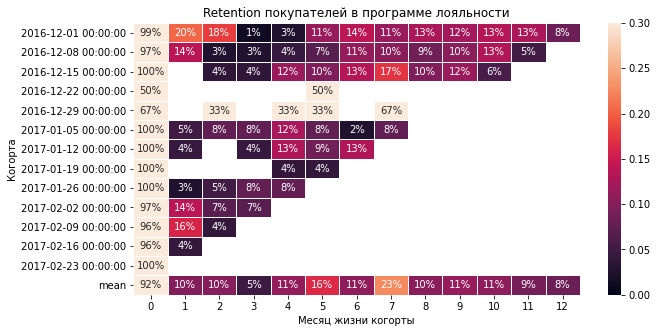

In [52]:
plt.figure(figsize=(10, 5))
plt.title('Retention покупателей в программе лояльности')
ax = sns.heatmap(cohorts_1_retention_pivot
            , annot=True, 
            fmt='.0%', 
            linewidths=1, 
            linecolor='white', 
            vmin=0.0, 
            vmax=0.3
           )
ax.set_xlabel('Месяц жизни когорты')
ax.set_ylabel('Когорта')
plt.savefig('saved_figure5.png', dpi = 100, bbox_inches='tight')
plt.show()

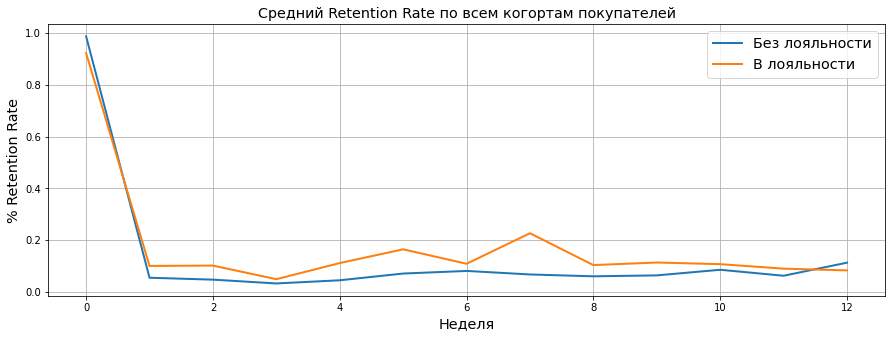

In [53]:
ax = cohorts_0_retention_pivot.loc['mean'].T.plot(linewidth = 2, figsize=(15, 5), label='Без лояльности')
cohorts_1_retention_pivot.loc['mean'].T.plot(ax=ax, linewidth = 2, label='В лояльности', grid=True)
    
plt.ylabel('% Retention Rate', fontsize='x-large')
plt.xlabel('Неделя', fontsize='x-large')
ax.legend(fontsize='x-large')
plt.title('Средний Retention Rate по всем когортам покупателей', fontsize='x-large')
plt.savefig('saved_figure2.png', dpi = 100, bbox_inches='tight') 
plt.show()

Судя по тепловой карте и общему графику, покупатели в ПЛ возвращаются в магазин немного чаще, начиная с первой недели жизни когорты. Но процент возвратов не стабилен, он плавает. Например, в когорте 2016-12-15 Retention Rate из низов поднимается, потом снова падает и поднимается. Похожее поведение и в других когортах. 

Несмотря на то, что в целом показатель Retention Rate немного лучше у лояльных клиентов, мы не можем утверждать, что это заслуга именно программы лояльности, а не сезонной рекламы, например, которая и объяснила бы такие скачки.

### Рассчитать LTV по когортам и неделям. Построить тепловые карты с накоплением. <a name="subparagraph4"></a>

LTV — «пожизненная» ценность клиента — итоговая сумма денег,
которую один клиент приносит в среднем со всех своих покупок. 

In [54]:
cohorts_0['ltv'] = cohorts_0['total'] / cohorts_0['customerid_all'] 
cohorts_1['ltv'] = cohorts_1['total'] / cohorts_1['customerid_all']

In [55]:
cohorts_0_ltv_pivot = cohorts_0.pivot_table(index='first_week', 
                                  columns='cohort_lifetime', 
                                  values='ltv', 
                                  aggfunc='mean').cumsum(axis=1)
cohorts_0_ltv_pivot.loc['mean'] = cohorts_0_ltv_pivot.mean() # расчет среднего retention среди всех когорт по времени жизни

cohorts_1_ltv_pivot = cohorts_1.pivot_table(index='first_week', 
                                  columns='cohort_lifetime', 
                                  values='ltv', 
                                  aggfunc='mean').cumsum(axis=1)
cohorts_1_ltv_pivot.loc['mean'] = cohorts_1_ltv_pivot.mean() 

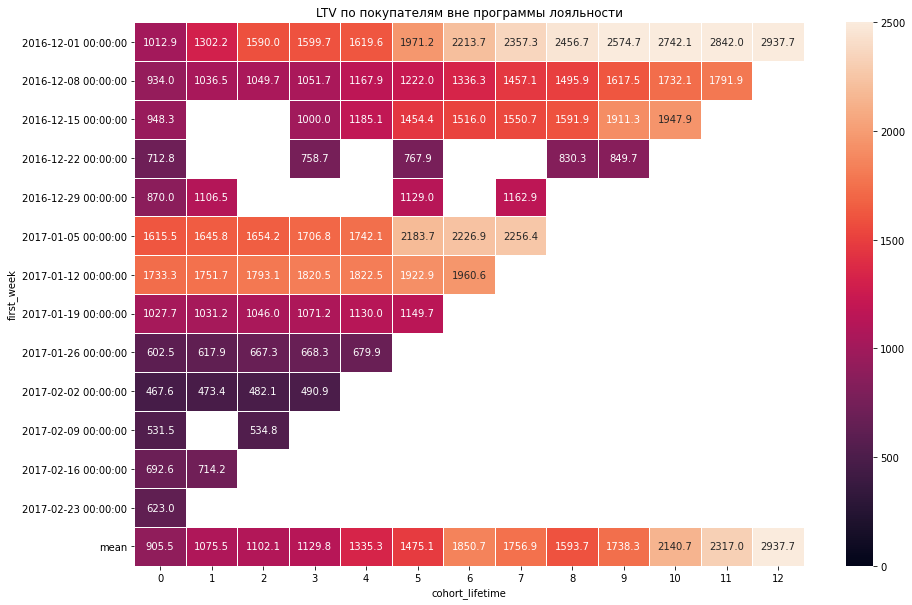

In [56]:
plt.figure(figsize=(15, 10))
plt.title('LTV по покупателям вне программы лояльности')
sns.heatmap(cohorts_0_ltv_pivot, 
            annot=True, fmt='.1f', 
            linewidths=1, 
            linecolor='white', 
            vmin=0.0, 
            vmax=2500)
plt.show()

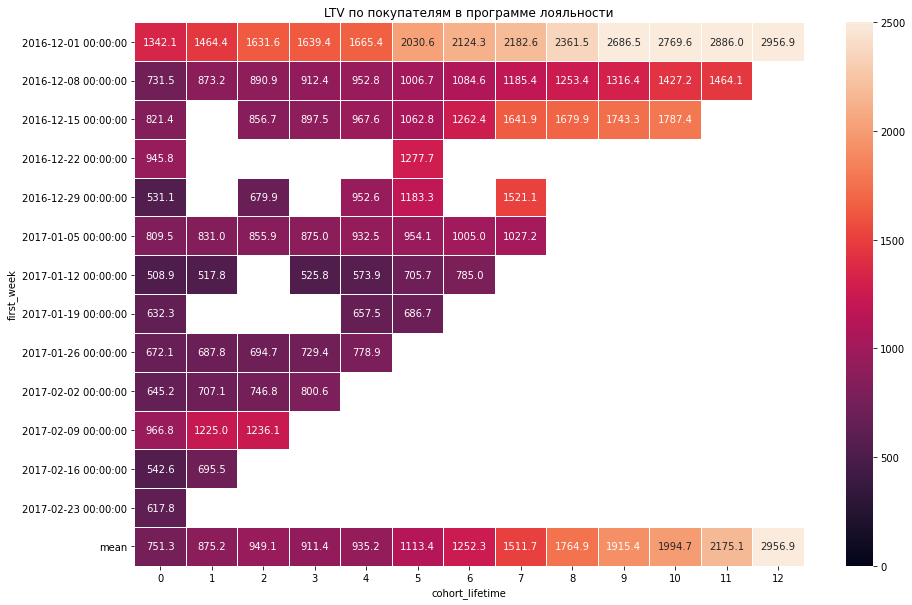

In [57]:
plt.figure(figsize=(15, 10))
plt.title('LTV по покупателям в программе лояльности')
sns.heatmap(cohorts_1_ltv_pivot, 
            annot=True, fmt='.1f', 
            linewidths=1, 
            linecolor='white', 
            vmin=0.0, 
            vmax=2500)
plt.show()

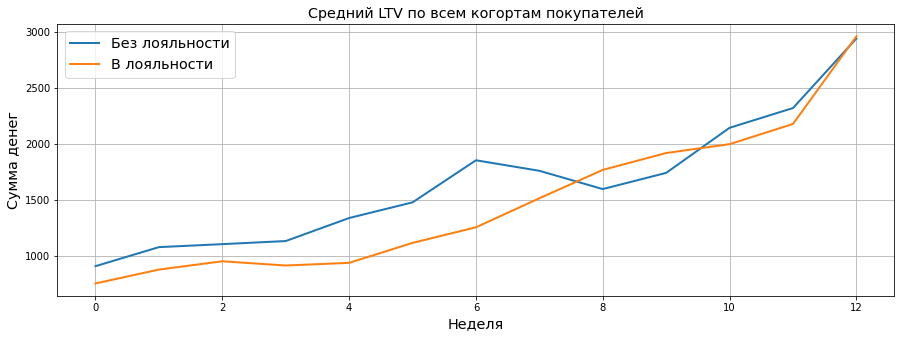

In [58]:
ax = cohorts_0_ltv_pivot.loc['mean'].T.plot(linewidth = 2, figsize=(15, 5), label='Без лояльности')
cohorts_1_ltv_pivot.loc['mean'].T.plot(ax=ax, linewidth = 2, label='В лояльности', grid=True)
    
plt.ylabel('Сумма денег', fontsize='x-large')
plt.xlabel('Неделя', fontsize='x-large')
ax.legend(fontsize='x-large')
plt.title('Средний LTV по всем когортам покупателей', fontsize='x-large')
#plt.savefig('saved_figure3.png', dpi = 100, bbox_inches='tight') 
plt.show()

Показатели LTV не демострируют превосходства ценности лояльного клиента над нелояльным, даже наоборот, в течение 7 недель покупатель из группы нелояльных приносит больше денег, потом на 2 недели лидерство меняется и, в конце концов, показатели LTV по группам сходятся.
Вероятно, ПЛ не стимулирует к большим тратам и покупкам.

In [59]:
cohorts_0.to_csv('cohorts_0.csv', index=False)
cohorts_1.to_csv('cohorts_1.csv', index=False)

In [60]:
cohorts_0['loality'] = False

In [61]:
all_cohorts = pd.concat([cohorts_1, cohorts_0], ignore_index=True)

In [62]:
all_cohorts.to_csv('all_cohorts.csv', index=False)

In [63]:
all_cohorts

,first_week,cohort_lifetime,customerid,total,customerid_all,retention,ltv,loality
0,2016-12-01,0,155,210715.01,157,0.987261,1342.133822,NaN
1,2016-12-01,1,32,19202.14,157,0.203822,122.306624,NaN
2,2016-12-01,2,28,26249.16,157,0.178344,167.192102,NaN
3,2016-12-01,3,2,1226.49,157,0.012739,7.812038,NaN
4,2016-12-01,4,4,4076.63,157,0.025478,25.965796,NaN
...,...,...,...,...,...,...,...,...
147,2017-02-09,0,70,37201.77,70,1.000000,531.453857,False
148,2017-02-09,2,1,237.38,70,0.014286,3.391143,False
149,2017-02-16,0,95,65797.57,95,1.000000,692.606000,False
150,2017-02-16,1,4,2047.20,95,0.042105,21.549474,False


### Рассчитать среднее количество товаров, покупаемых по неделям, и средние чеки. Построить графики. <a name="subparagraph5"></a>

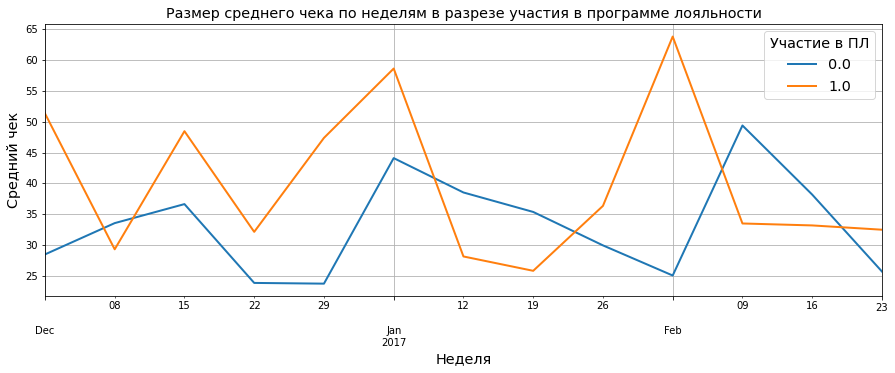

In [64]:
purchase_retail.pivot_table(index='loyalty_program', 
                         columns='next_week', 
                         values='total', 
                         aggfunc='mean'
                        ).T.plot(linewidth = 2, figsize=(15, 5), grid=True)
plt.legend(title='Участие в ПЛ', title_fontsize='x-large', fontsize='x-large')
plt.ylabel('Средний чек', fontsize='x-large')
plt.xlabel('Неделя', fontsize='x-large')
plt.title('Размер среднего чека по неделям в разрезе участия в программе лояльности', fontsize='x-large')
#plt.savefig('saved_figure4.png', dpi = 100, bbox_inches='tight') 
plt.show()

In [65]:
purchase_retail.to_csv('purchase_retail.csv', index=False)

In [66]:
print('Размер среднего чека для неучастников ПЛ {:.0f}'.
      format(purchase_retail.query('loyalty_program == 0.0').pivot_table(index='loyalty_program', 
                         columns='next_week', 
                         values='total', 
                         aggfunc='mean'
                        ).mean().mean()
            ))

print('Размер среднего чека для участников ПЛ {:.0f}'.
      format(purchase_retail.query('loyalty_program == 1.0').pivot_table(index='loyalty_program', 
                         columns='next_week', 
                         values='total', 
                         aggfunc='mean'
                        ).mean().mean()
            ))

Размер среднего чека для неучастников ПЛ 33
Размер среднего чека для участников ПЛ 40


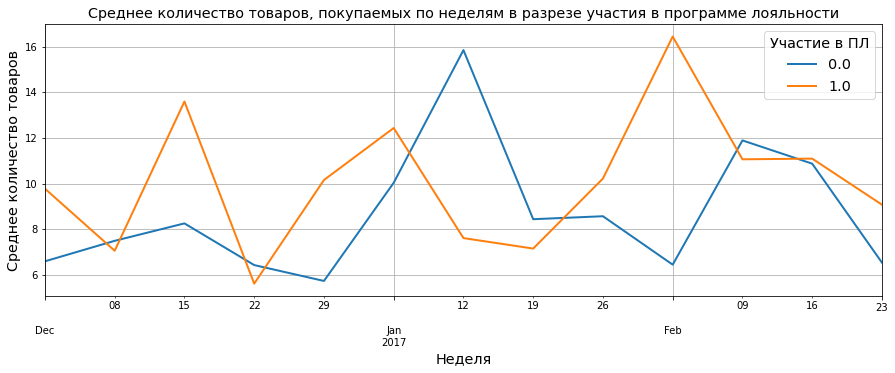

In [67]:
purchase_retail.pivot_table(index='loyalty_program', 
                         columns='next_week', 
                         values='quantity', 
                         aggfunc='mean'
                        ).T.plot(linewidth = 2, figsize=(15, 5), grid=True)
plt.legend(title='Участие в ПЛ', title_fontsize='x-large', fontsize='x-large')
plt.ylabel('Среднее количество товаров', fontsize='x-large')
plt.xlabel('Неделя', fontsize='x-large')
plt.title('Среднее количество товаров, покупаемых по неделям в разрезе участия в программе лояльности', fontsize='x-large')
#plt.savefig('saved_figure5.png', dpi = 100, bbox_inches='tight') 
plt.show()

In [68]:
print('Среднее количество купленных товаров для неучастников ПЛ {:.0f}'.
      format(purchase_retail[purchase_retail['loyalty_program'] == 0.0]['quantity'].mean()))
print('Среднее количество купленных товаров для участников ПЛ {:.0f}'.
      format(purchase_retail[purchase_retail['loyalty_program'] == 1.0]['quantity'].mean()))

Среднее количество купленных товаров для неучастников ПЛ 9
Среднее количество купленных товаров для участников ПЛ 10


Плавающие графики среднего чека и средних покупок не выявляют лидера или чье-то преимущество. Показатели буквально скачут и не дают ответа на вопрос о том, что на эти скачки влияет. 

### Анализ возвратов: средний чек и среднее количество. <a name="subparagraph6"></a>

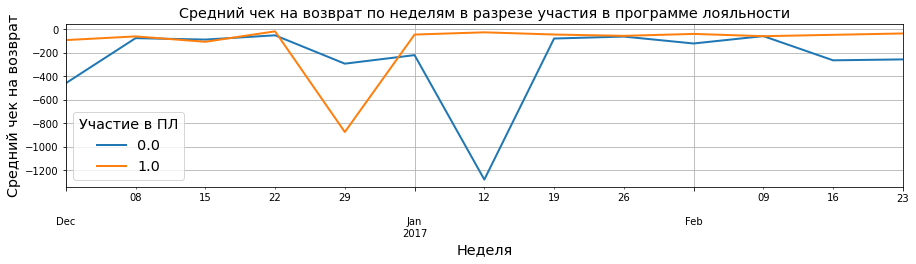

In [69]:
cancelled_retail.pivot_table(index='loyalty_program', 
                         columns='next_week', 
                         values='total', 
                         aggfunc='mean'
                        ).T.plot(linewidth = 2, figsize=(15, 3), grid=True)
plt.legend(title='Участие в ПЛ', title_fontsize='x-large', fontsize='x-large')
plt.ylabel('Средний чек на возврат', fontsize='x-large')
plt.xlabel('Неделя', fontsize='x-large')
plt.title('Средний чек на возврат по неделям в разрезе участия в программе лояльности', fontsize='x-large')
plt.savefig('saved_figure9.png', dpi = 100, bbox_inches='tight') 
plt.show()

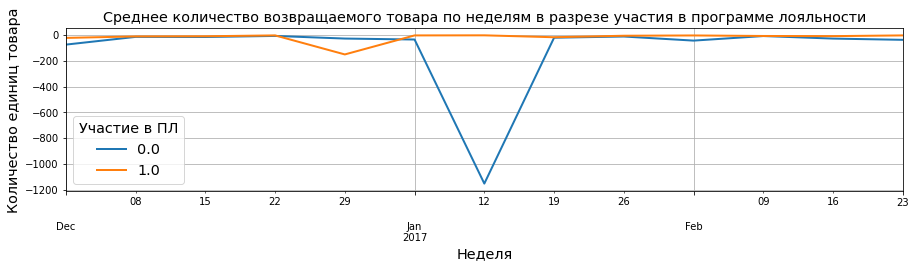

In [70]:
cancelled_retail.pivot_table(index='loyalty_program', 
                         columns='next_week', 
                         values='quantity', 
                         aggfunc='mean'
                        ).T.plot(linewidth = 2, figsize=(15, 3), grid=True)
plt.legend(title='Участие в ПЛ', title_fontsize='x-large', fontsize='x-large')
plt.ylabel('Количество единиц товара', fontsize='x-large')
plt.xlabel('Неделя', fontsize='x-large')
plt.title('Среднее количество возвращаемого товара по неделям в разрезе участия в программе лояльности', fontsize='x-large')
plt.savefig('saved_figure10.png', dpi = 100, bbox_inches='tight') 
plt.show()

Графики возвратов по сумме и количеству схожи у двух групп покупателей. Мы видим два больших пика на неделях 29-12-2016 и 12-01-2017, но это единичные выбросы, которые не отражают истинную картину различий.

## Выводы:  <a name="paragraph5"></a>

### Как участие влияет на частоту покупок.

Судя по тепловой карте и общему графику, покупатели в ПЛ возвращаются в магазин немного чаще. Но процент возвратов не стабилен, он плавает. Например, в когорте 2016-12-15 Retention Rate из низов поднимается, потом снова падает и поднимается. Похожее поведение и в других когортах. 
Несмотря на то, что в целом показатель Retention Rate немного лучше у лояльных клиентов, мы не можем утверждать, что это заслуга именно программы лояльности, а не сезонной рекламы, например, которая и объяснила бы такие скачки.

Можем сделать вывод о том, что покупатели в программе лояльности совершают покупки несколько чаще, но точная корреляция между фактом участия и частотой покупок установлена не была, скорее всего имеют влияние другие факторы.

### Как участие в программе лояльности влияет на количество денег, приносимых одним клиентом.

Анализ показателя LTV, который отражает ценность клиента и то, сколько денег приносит в среднем один человек, мог бы дать нам ясную картину и ответ на вопрос. Но и здесь этого не произошло. LTV нелояльных даже выше вплоть до седьмой недели собранных данных. Это значит, что покупатель вне ПЛ в среднем тратит больше, хотя стимула в виде особой программы у него и нет.

Участники же ПЛ показывают снова нестабильный результат, поэтому вероятно и тут на показатели ценности влияют другие факторы.

### Как участие влияет на средний чек, количество покупок и возвраты.

Как и с предыдущими метриками, анализ метрик Среднего чека, количества покупок и возвратов не показал нам превосходства и эффективности программы лояльности.

Участники программы лояльности не демонстрируют превосходящих иную группу результатов по нашим метрикам. Имея особый стимул к покупкам и посещениям, показатели у участников ПЛ чаще даже ниже, чем у неучастников. Стоит напомнить, что из всех цен каталога при присвоении их к товарам, мы брали максимальную, хотя вероятно участники ПЛ совершали покупки по сниженым ценам. Значит показатель ценности клиента из ПЛ и его среднего чека еще меньше, чем получилось у нас.

Программа лояльности скорее неэффективна, поскольку не приносит прибыль больше.